<a href="https://colab.research.google.com/github/Grcf2585/RESSBIO/blob/main/S2_water_index.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Install the required libraries**

In [ ]:
!pip install -U geemap
!pip install earthengine-api
!pip install PyShp
!pip install PyCRS
!pip install geopandas
!pip install pygal
!pip install ipygee
!pip install mss
#geemap.update_package()

**Import libraries**

In [2]:
import ee
import geemap
import geemap.colormaps as cm

from ipyleaflet import *
from ipywidgets import Label
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import scipy.io
import os
import pickle
import datetime
import array

import pycrs
import shapely
import shapefile as shp
from shapely.geometry import mapping
from shapely.geometry import box

import pygal
import ipygee as ui
from ipygee import *
from ipygee import chart

**Mount GitHub repository**

In [3]:
!rm -r RESSBIO # delete the complete repository folder 
!git clone https://github.com/Grcf2585/RESSBIO # clone repository folder
sys.path.insert(0,'/content/RESSBIO')

rm: cannot remove 'RESSBIO': No such file or directory
Cloning into 'RESSBIO'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (142/142), done.
remote: Compressing objects: 100% (116/116), done.
remote: Total 147 (delta 67), reused 63 (delta 21), pack-reused 5
Receiving objects: 100% (147/147), 6.39 MiB | 5.52 MiB/s, done.
Resolving deltas: 100% (67/67), done.


**Mount Google Drive**

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Authenticate and initialize ee**

In [5]:
try:
    ee.Initialize()
except Exception as e:
    ee.Authenticate()
    ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=vwxOyhG3lpckk4n7U0hOpJd6R3kC8tbXO5OQLVl7azE&tc=d1mJgAlmWPhuWqcXIgU4ytWP2dN2xRhv40an1bG6z_A&cc=5xhJQM1zAUferxn_4hXVD3KGFn_AbFiZ3jtxho-Z6KU

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AbUR2VN5PmToPKTxXblgshKMerwjS9ehPCPojD5odSwWw-ZNbm5hS0qaoSs

Successfully saved authorization token.


**Select the Area of Interest**

In [6]:
Map = geemap.Map(toolbar_ctrl=True, layer_ctrl=True)
Map.default_style = {'cursor': 'crosshair'}
Map.add_basemap('SATELLITE')

# Center the map in the desired country
country = 'Spain'
country_bounds = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017").filterMetadata('country_na', 'equals', country);
Map.centerObject(country_bounds,8)
Map

Map(center=[40.35722509547827, -3.499564837147696], controls=(WidgetControl(options=['position', 'transparent_…

**Retrieve the ROI from the map**

In [7]:
roi_N = geemap.shp_to_ee('/content/RESSBIO/ROIs Albufera/N_Polygon.shp')
Map.addLayer(roi_N, {},'Albufera ROI_N',True)

roi_S = geemap.shp_to_ee('/content/RESSBIO/ROIs Albufera/S_Polygon.shp')
Map.addLayer(roi_S, {},'Albufera ROI_S',True)

roi_NW = geemap.shp_to_ee('/content/RESSBIO/ROIs Albufera/NW_Polygon.shp')
Map.addLayer(roi_NW, {},'Albufera ROI_NW',True)

roi_SW = geemap.shp_to_ee('/content/RESSBIO/ROIs Albufera/SW_Polygon.shp')
Map.addLayer(roi_SW, {},'Albufera ROI_SW',True)
 
roi_W = geemap.shp_to_ee('/content/RESSBIO/ROIs Albufera/W_Polygon.shp')
Map.addLayer(roi_W, {},'Albufera ROI_W',True)

roi_Albufera = geemap.shp_to_ee('/content/RESSBIO/ROIs Albufera/Albufera curvas.shp')
Map.addLayer(roi_Albufera, {},'Albufera ROI',True)


In [ ]:
#feature = Map.draw_last_feature
#roi_show_map = feature.geometry()

**Model import**

In [8]:
!cp /content/RESSBIO/Models/GEE_GPR_10KCV_CHL_model.py . 
!cp /content/RESSBIO/Models/GEE_GPR_4KCV_PC_model.py .
!cp /content/RESSBIO/Models/GEE_GPR_4KCV_SDD_model.py .

import GEE_GPR_10KCV_CHL_model
import GEE_GPR_4KCV_PC_model
import GEE_GPR_4KCV_SDD_model

In [9]:
# In-situ data loading
Albufera_insitu_data = scipy.io.loadmat('/content/RESSBIO/In situ data/Centro_Insitu_Albufera_2016_2023.mat',squeeze_me=True)
X_insitu = np.array(Albufera_insitu_data['Insitu_date'])
X_insitu = pd.to_datetime(X_insitu-719529, unit='D')
Chl_insitu = Albufera_insitu_data['Chlorophyll']
Secchi_insitu = Albufera_insitu_data['Secchi']

**Functions**

In [10]:
# Auxiliar function for mapping : (1..n) -> (B1..Bn)
def band_names(element):
  bandName = ee.String('B').cat(ee.Number(element).int().format())
  return bandName

def addDoy(image):
  doy = image.date().getRelative('day', 'year')
  doyBand = ee.Image.constant(doy).uint16().rename('doy')
  return image.addBands(doyBand)

In [11]:
# Water variable GPR for mean prediction
def water_var_GPR(image_orig):
  
  # Create List of Bands of Dimension n (Xtrain[n,n])
  XTrain_dim = currentModel['X_train'].length().get([0]).getInfo();

  band_sequence   = (ee.List.sequence(1, XTrain_dim)
                    .map(band_names));
  
  # Create a list of band names for flattening operation 
  im_norm_ell2D_hypell = image_orig.subtract(ee.Image(currentModel['mx'])).divide(ee.Image(currentModel['sx'])).multiply(ee.Image(currentModel['hyp_ell'])).toArray().toArray(1); 
  
  im_norm_ell2D = image_orig.subtract(ee.Image(currentModel['mx'])).divide(ee.Image(currentModel['sx'])).toArray().toArray(1); 
  
  PtTPt  = im_norm_ell2D_hypell.matrixTranspose().matrixMultiply(im_norm_ell2D).arrayProject([0]).multiply(-0.5); 
  
  PtTDX  = ee.Image(currentModel['X_train']).matrixMultiply(im_norm_ell2D_hypell).arrayProject([0]).arrayFlatten([band_sequence]);
  
  arg1   = PtTPt.exp().multiply(currentModel['hyp_sig']);
  
  k_star = PtTDX.subtract(ee.Image(currentModel['XDX_pre_calc']).multiply(0.5)).exp().toArray();
  
  mean_pred = k_star.arrayDotProduct(ee.Image(currentModel['alpha_coefficients']).toArray()).multiply(arg1);
  
  mean_pred = mean_pred.toArray(1).arrayProject([0]).arrayFlatten([[currentModel['veg_index']]]);
  
  mean_pred = mean_pred.add(currentModel['mean_model']);
  
  # Mask values equal or less than 0
  mean_pred = mean_pred.updateMask(mean_pred.gt(0))
  
  image_orig = image_orig.addBands(mean_pred)
  
  return image_orig.select(currentModel['veg_index'])

In [12]:
def mask_gt(image):
  veg_index_mask = image.select(currentModel['veg_index']).gt(0).rename('veg_index_mask')
  return image.addBands(veg_index_mask).select('veg_index_mask')

def addVariables(image):
  date = ee.Date(image.get("system:time_start"))
  years = date.difference(ee.Date('1970-01-01'),'days')
  return image.addBands(ee.Image(years).rename('t').float())

In [13]:
def extract_ts(roi, col, band):
    """ Constructs a dataframe with the time series for the ROI with the image
        collection.

        Parameters
        ----------
        roi : ee.Geometry, Region of interest
        
        col : ee.ImageCollection
        
        band : string, Name of the band to retrieve
        
        Returns
        ------
        A pandas dataframe
        
    """
                
    # Auxiliar function to replace the null values with custom value(-9999)
    # so we do not lose the masked values.
    def set_NAN(key,val):       
        return ee.List([val, -9999]).reduce(ee.Reducer.firstNonNull())

    # Retrieve the mean value of the band in the roi and the date of the image
    def get_ts(image):        
        stat = image.select([band]).reduceRegion(
            reducer = ee.Reducer.mean(),
            geometry= roi,
            scale= 20,
            bestEffort= True        
        )
        stat = stat.map(set_NAN)
        return ee.Feature(roi, stat).set({'millis': image.date().millis()})
    
    # List of features containing the reduced value and the date
    ts = col.map(get_ts)
        
    # Lists of values and dates
    y = ts.aggregate_array(band).getInfo()
    dates_ms = ts.aggregate_array('millis').getInfo() # Date in ms
    x = [datetime.fromtimestamp(d//1000.0) for d in dates_ms] # Formatted date    
    
    # Dictionary that will feed the pandas dataframe
    dict = {'date': x, band: y} 
    # Contruct the df and replace the custom NaN values(-9999) with np.nan
    df = pd.DataFrame(dict).replace(-9999, np.nan)    
    return df

In [14]:
# Masking function for water and cloud
def maskS2cloud_and_water(image):
  not_water = image.select('SCL').neq(6);
  not_cloud_low = image.select('SCL').neq(7);
  not_cloud_medium = image.select('SCL').neq(8);
  not_cloud_high = image.select('SCL').neq(9);
  not_cirrus = image.select('SCL').neq(10);
  
  qa = image.select('QA60');
  cloudBitMask = 1 << 10;
  cirrusBitMask = 1 << 11;
  mask = (qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0)).And(not_water).And(not_cloud_low)
          .And(not_cloud_medium).And(not_cloud_high).And(not_cirrus))
  return image.updateMask(mask).divide(10000).copyProperties(qa).set('system:time_start', qa.get('system:time_start'))

In [15]:
#Function to mask clouds using the Sentinel-2 QA band
 
def maskS2clouds(image):
    qa = image.select('QA60');
    #Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10;
    cirrusBitMask = 1 << 11;

    #Both flags should be set to zero, indicating clear conditions.
    #mask = qa.bitwiseAnd(cloudBitMask).eq(0)and(qa.bitwiseAnd(cirrusBitMask).eq(0));
    mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0));

    return image.updateMask(mask).divide(10000).copyProperties(image).set("system:time_start", image.get("system:time_start"));

In [16]:
# Function to calculate and add Phycocyanin band
#ficocianina_S2 = #e^2.6151*(R740/R665)+3.6369;
#R740 nm = B6
#R665 nm = B4

def addFICOS2(image):
    fico = (((image.select('B6').divide(image.select('B4')).multiply(2.6151)).add(3.6369))).exp().rename('fico')

    return image.addBands(fico)

In [17]:
# Function to calculate and add Chlorophyll band
#TBDO = R740*(1/R665 - 1/R705)
#clorofila_S2 = 104.1*(TBDO^2) + 221.1*TBDO + 2
#R665 = B4
#R705 = B5
#R740 = B6

def addCHLROS2(image):
    tbdo = (image.select('B6').divide(image.select('B4'))).subtract(image.select('B6').divide(image.select('B5')))
    chlro =  ((tbdo.multiply(tbdo).multiply(104.1).add(tbdo.multiply(221.1))).add(2)).rename('chlro')

    return image.addBands(chlro)

In [18]:
# Function to calculate and add Secchi band
#profundidad_Secchi_S2 =  0.224*(R560/R704)+0.0836
#R560 nm = B3
#R704 nm = B5

def addSECCHIS2(image):
    Secchi = ((image.select('B3').divide(image.select('B5')).multiply(0.224)).add(0.0836)).rename('Secchi')
    return image.addBands(Secchi)

In [19]:
# Clipping image collection by Albufera geometry
def clipcol(image):
    clipimage = image.clip(roi_Albufera)
    return clipimage

# Add NDWI band to image collection
def addNDWI(image):
    return image.addBands(image.normalizedDifference(['B3', 'B5']).rename('NDWI'));

# Function to mask out NDWI
def S2maskedWater(image):
    NDWI = image.select(['NDWI']);
    return image.addBands(ee.Image(1).updateMask(NDWI.gte(-0.3)).rename('NDWI_mask')); #lte

# Function to mask out Phycocyanin values greater than 3000
def S2maskPC(image):
    PC = image.select(['fico']);
    return image.updateMask(PC.lte(3000)); #lte

def maskBands(image):
  return image.select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8A','NDWI']).updateMask(image.select('NDWI_mask'));


Dates of interest and acquisitions configuration parameters

In [20]:
# Configuration Parameters
start_date = '2017-03-28'
end_date = '2023-05-04'
S2_CPP = 3 # CLOUDY_PIXEL_PERCENTAGE
#roi = roi_show_map
roi = roi_N.geometry() # Select the current region of interest, the options are: roi_N, roi_S, roi_W, roi_SW, and roi_NW. 
geometry = roi_Albufera # The Albufera mask is copied as geometry to filter the image collection posteriorly. 

Create the initial image collection with the spectral bands

In [21]:
# Retrieving Sentinel 2 imagery 
print('SENTINEL-2 time series being retrieved')
S2collection_raw = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')\
                   .filterBounds(roi)\
                   .filterDate(start_date,end_date)\
                   .map(maskS2clouds)\
                   .filterMetadata('CLOUDY_PIXEL_PERCENTAGE','less_than', S2_CPP)\
                   .select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8A'])\
          
# Apply water masking functions to the image collection
S2collection_aux = S2collection_raw.map(addNDWI).map(S2maskedWater).map(maskBands);  
S2collection_ini = S2collection_aux.map(clipcol).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7','B8A']);

SENTINEL-2 time series being retrieved


S2 dates extraction

In [22]:
# Creating labels - Multitemporal plotting 
labels_S2 = S2collection_ini.aggregate_array("system:index").getInfo()

# Dates S2
Dates_S2 = []
for i in labels_S2:
    Dates_S2.append(datetime.datetime.strptime(i.split('_')[0].split('T')[0], '%Y%m%d').date())
Dates_S2.sort()

#datetime.datetime.strptime(date, "%Y-%m-%d")
#https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime

Creating the retrieved image collection by applying Gaussian Process Regression

In [23]:
#GPR retrieval model configuration (Chlorophyll)

currentwatervariable ='Chl'
currentModel = GEE_GPR_10KCV_CHL_model.models[currentwatervariable]
S2_GPR_CHL_collection =  S2collection_ini.map(water_var_GPR).select(currentModel['veg_index'])
del currentwatervariable
del currentModel 

#GPR retrieval model configuration (Phycocyanin)
currentwatervariable ='PC'
currentModel = GEE_GPR_4KCV_PC_model.models[currentwatervariable]
S2_GPR_PC_collection =  S2collection_ini.map(water_var_GPR).select(currentModel['veg_index'])
del currentwatervariable
del currentModel 

#GPR retrieval model configuration (Secchi Disc Depth)
currentwatervariable ='ZSD'
currentModel = GEE_GPR_4KCV_SDD_model.models[currentwatervariable]
S2_GPR_SDD_collection =  S2collection_ini.map(water_var_GPR).select(currentModel['veg_index'])
del currentwatervariable
del currentModel 

Creating the retrieved image collection by applying parametric indices

In [24]:
# Add the Chlorophyll band to the image collection
S2_PI_CHL_collection = S2collection_ini.map(addCHLROS2).select('chlro')

# Add Phycocyanin band to the image collection
S2_PI_PC_collection = S2collection_ini.map(addFICOS2).map(S2maskPC).select('fico')

# Add Secchi Disc Band band to the image collection
S2_PI_SDD_collection = S2collection_ini.map(addSECCHIS2).select('Secchi')

S2 image collection to a numpy array conversion

In [25]:
# GPR image collections conversion

S2_GPR_CHL_image = S2_GPR_CHL_collection.toBands().unmask(0); 
S2_GPR_CHL_image_nparray = geemap.ee_to_numpy(ee_object = S2_GPR_CHL_image.toArray(), region=roi, default_value=None)

S2_GPR_PC_image = S2_GPR_PC_collection.toBands().unmask(0);
S2_GPR_PC_image_nparray = geemap.ee_to_numpy(ee_object = S2_GPR_PC_image.toArray(), region=roi, default_value=None)

S2_GPR_SDD_image = S2_GPR_SDD_collection.toBands().unmask(0);
S2_GPR_SDD_image_nparray = geemap.ee_to_numpy(ee_object = S2_GPR_SDD_image.toArray(), region=roi, default_value=None)

# PI image collections conversion

S2_PI_CHL_image = S2_PI_CHL_collection.toBands().unmask(0);
S2_PI_CHL_image_nparray = geemap.ee_to_numpy(ee_object = S2_PI_CHL_image.toArray(), region=roi, default_value=None)

S2_PI_PC_image = S2_PI_PC_collection.toBands().unmask(0);
S2_PI_PC_image_nparray = geemap.ee_to_numpy(ee_object = S2_PI_PC_image.toArray(), region=roi, default_value=None)

S2_PI_SDD_image = S2_PI_SDD_collection.toBands().unmask(0);
S2_PI_SDD_image_nparray = geemap.ee_to_numpy(ee_object = S2_PI_SDD_image.toArray(), region=roi, default_value=None)

print('S2 ROI Dimension')
print(S2_GPR_CHL_image_nparray.shape)

S2 ROI Dimension
(42, 43, 234)


In [26]:
# GPR numpy array images parcel mean calculations

S2_GPR_CHL_parcel_mean = S2_GPR_CHL_image_nparray.mean(axis=1).mean(axis=0)
S2_GPR_CHL_parcel_std = np.std(S2_GPR_CHL_parcel_mean, axis=0)

S2_GPR_PC_parcel_mean = S2_GPR_PC_image_nparray.mean(axis=1).mean(axis=0)
S2_GPR_PC_parcel_std = np.std(S2_GPR_PC_parcel_mean, axis=0)

S2_GPR_SDD_parcel_mean = S2_GPR_SDD_image_nparray.mean(axis=1).mean(axis=0)
S2_GPR_SDD_parcel_std = np.std(S2_GPR_SDD_parcel_mean, axis=0)

# PI numpy array images parcel mean calculations

S2_PI_CHL_parcel_mean = S2_PI_CHL_image_nparray.mean(axis=1).mean(axis=0)
S2_PI_CHL_parcel_std = np.std(S2_PI_CHL_parcel_mean, axis=0)

S2_PI_PC_parcel_mean = S2_PI_PC_image_nparray.mean(axis=1).mean(axis=0)
S2_PI_PC_parcel_std = np.std(S2_PI_PC_parcel_mean, axis=0)

S2_PI_SDD_parcel_mean = S2_PI_SDD_image_nparray.mean(axis=1).mean(axis=0)
S2_PI_SDD_parcel_std = np.std(S2_PI_SDD_parcel_mean, axis=0)

S2 time-series plotting

In [ ]:
#Comparative Graphs

axmaxloc = S2_PI_CHL_image_nparray.shape[2]/4;
axminloc = S2_PI_CHL_image_nparray.shape[2]/4;

# Sentinel 2 Chlorophyll parametric index model vs GPR model time series plotting 

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(Dates_S2,S2_PI_CHL_parcel_mean,linestyle="--",marker="o",markerfacecolor='c',markeredgecolor='k',markersize=6,lw=3,label='S2 Chl-a parametric model')
plt.fill_between(Dates_S2, S2_PI_CHL_parcel_mean-S2_PI_CHL_parcel_std,S2_PI_CHL_parcel_mean+S2_PI_CHL_parcel_std ,alpha=0.25,color='grey',label='S2 Chl-a (index) + 1*std')
plt.plot(Dates_S2,S2_GPR_CHL_parcel_mean,linestyle="--",marker="o",markerfacecolor='m',markeredgecolor='k',markersize=6,lw=3,label='S2 Chl-a GPR model')
plt.fill_between(Dates_S2, S2_GPR_CHL_parcel_mean-S2_GPR_CHL_parcel_std,S2_GPR_CHL_parcel_mean+S2_GPR_CHL_parcel_std ,alpha=0.25,color='green',label='S2 Chl-a (GPR) + 1*std')
#plt.title('S2 Chlorophyll ROI comparison')
plt.legend()
plt.grid(1)
plt.ylabel('Chlorophyll [$\mu$g $L^{-1}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

# Sentinel 2 Phycocyanin parametric index model vs GPR model time series plotting 

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(Dates_S2,S2_PI_PC_parcel_mean,linestyle="--",marker="o",markerfacecolor='r',markeredgecolor='k',markersize=6,lw=3,label='S2 PC parametric model')
plt.fill_between(Dates_S2, S2_PI_PC_parcel_mean-S2_PI_PC_parcel_std,S2_PI_PC_parcel_mean+S2_PI_PC_parcel_std ,alpha=0.25,color='grey',label='S2 PC (index) + 1*std')
plt.plot(Dates_S2,S2_GPR_PC_parcel_mean,linestyle="--",marker="o",markerfacecolor='y',markeredgecolor='k',markersize=6,lw=3,label='S2 PC GPR model')
plt.fill_between(Dates_S2, S2_GPR_PC_parcel_mean-S2_GPR_PC_parcel_std,S2_GPR_PC_parcel_mean+S2_GPR_PC_parcel_std ,alpha=0.25,color='blue',label='S2 PC (GPR) + 1*std')
#plt.title('S2 Phycocyanin ROI comparison')
plt.legend()
plt.grid(1)
plt.ylabel('Phycocyanin [$\mu$g $L^{-1}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

# Sentinel 2 Secchi Disk Depth parametric index model vs GPR model time series plotting 

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

plt.plot(Dates_S2,S2_PI_SDD_parcel_mean,linestyle="--",marker="o",markerfacecolor='white',markeredgecolor='k',markersize=6,lw=3,label='S2 SDD parametric model')
plt.fill_between(Dates_S2, S2_PI_SDD_parcel_mean-S2_PI_SDD_parcel_std,S2_PI_SDD_parcel_mean+S2_PI_SDD_parcel_std ,alpha=0.25,color='grey',label='S2 SDD (index) + 1*std')
plt.plot(Dates_S2,S2_GPR_SDD_parcel_mean,linestyle="--",marker="o",markerfacecolor='blue',markeredgecolor='k',markersize=6,lw=3,label='S2 SDD GPR model')
plt.fill_between(Dates_S2, S2_GPR_SDD_parcel_mean-S2_GPR_SDD_parcel_std,S2_GPR_SDD_parcel_mean+S2_GPR_SDD_parcel_std ,alpha=0.25,color='red',label='S2 SDD (GPR) + 1*std')
#plt.title('S2 Secchi disc depth ROI comparison')
plt.legend()
plt.grid(1)
plt.ylabel('Secchi disc depth [m]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

**Water parameter mapping**

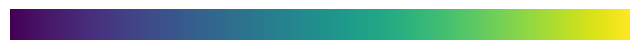

In [28]:
palette_PC = cm.get_palette('viridis', n_class=10)
vis_PC = {'min': 0, 'max': 1200, 'palette': palette_PC}
cm.plot_colormap('viridis', width=8.0, height=0.4, orientation='horizontal')

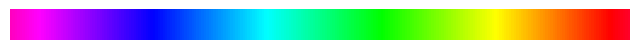

In [29]:
palette_CHL = cm.get_palette('gist_rainbow_r', n_class=10)
vis_CHL = {'min': 0, 'max': 300, 'palette': palette_CHL}
cm.plot_colormap('gist_rainbow_r', width=8.0, height=0.4, orientation='horizontal')

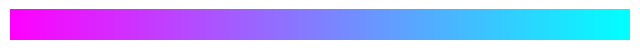

In [30]:
palette_SDD = cm.get_palette('cool_r', n_class=10)
vis_SDD = {'min': 0.25, 'max': 0.45, 'palette': palette_SDD}
cm.plot_colormap('cool_r', width=8.0, height=0.4, orientation='horizontal')

In [31]:
# Map display parameters definition (RGB S2 image)
vizParams = {
  'bands': ['B4', 'B3', 'B2'],
  'min': 0,
  'max': 0.2,
}
#cm.list_colormaps()

In [32]:
u_lat = 39.34
u_lon = -0.35

Map_S2 = geemap.Map(center=(u_lat,u_lon), zoom=13,toolbar_ctrl=True, layer_ctrl=True)
Map_S2.set_plot_options(add_marker_cluster=True)
Map_S2

Map(center=[39.34, -0.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [33]:
# S2-based water ecological parameters map display

image_number = 2 # select the ordinal number of the image you want to be displayed

# Converting the S2 image collection to an image list for RGB scene display
S2collection_list = S2collection_raw.toList(S2collection_raw.size());
S2image = ee.Image(S2collection_list.get(image_number));

# S2 RGB image display

Map_S2.addLayer(S2image,vizParams,'S2 RGB composite',True)

# Single variable display

S2_GPR_CHL_image = S2_GPR_CHL_collection.toBands()
S2_GPR_PC_image = S2_GPR_PC_collection.toBands()
S2_GPR_SDD_image = S2_GPR_SDD_collection.toBands()
S2_PI_CHL_image = S2_PI_CHL_collection.toBands()
S2_PI_PC_image = S2_PI_PC_collection.toBands()
S2_PI_SDD_image = S2_PI_SDD_collection.toBands()

Map_S2.addLayer(S2_GPR_CHL_image.select(image_number),vis_CHL, 'S2 GPR CHL')
#Map_S2.addLayer(S2_GPR_PC_image.select(image_number),vis_PC, 'S2 GPR PC')
#Map_S2.addLayer(S2_GPR_SDD_image.select(image_number),vis_PC, 'S2 GPR SDD')
#Map_S2.addLayer(S2_PI_CHL_image.select(image_number),vis_CHL, 'S2 PI CHL')
#Map_S2.addLayer(S2_PI_PC_image.select(image_number),vis_PC, 'S2 PI PC')
#Map_S2.addLayer(S2_PI_SDD_image.select(image_number),vis_SDD, 'S2 PI SDD')

# Variables collection display (mean, max or min).

#Map_S2.addLayer(S2_GPR_CHL_collection.mean(),vis_CHL, 'S2 GPR CHL collection')
#Map_S2.addLayer(S2_GPR_PC_collection.mean(),vis_PC, 'S2 GPR PC collection')
#Map_S2.addLayer(S2_GPR_SDD_collection.mean(),vis_SDD, 'S2 GPR SDD collection')
#Map_S2.addLayer(S2_PI_CHL_collection.mean(),vis_CHL, 'S2 PI CHL collection')
#Map_S2.addLayer(S2_PI_PC_collection.mean(),vis_PC, 'S2 PI PC collection')
#Map_S2.addLayer(S2_PI_SDD_collection.mean(),vis_SDD, 'S2 PI SDD collection')

# On-screen display of variable time sliders

#Map_S2.add_time_slider(S2_GPR_CHL_collection ,vis_CHL, region=roi_Albufera,layer_name='S2 GPR CHL time-series',labels=labels_S2, time_interval=1)
#Map_S2.add_time_slider(S2_GPR_PC_collection ,vis_PC, region=roi_Albufera,layer_name='S2 GPR PC time-series',labels=labels_S2, time_interval=1)
#Map_S2.add_time_slider(S2_GPR_SDD_collection ,vis_SDD, region=roi_Albufera,layer_name='S2 GPR SDD time-series',labels=labels_S2, time_interval=1)
#Map_S2.add_time_slider(S2_PI_CHL_collection ,vis_CHL, region=roi_Albufera,layer_name='S2 PI CHL time-series',labels=labels_S2, time_interval=1)
#Map_S2.add_time_slider(S2_PI_PC_collection ,vis_PC, region=roi_Albufera,layer_name='S2 PI PC time-series',labels=labels_S2, time_interval=1)
#Map_S2.add_time_slider(S2_PI_SDD_collection ,vis_SDD, region=roi_Albufera,layer_name='S2 PI SDD time-series',labels=labels_S2, time_interval=1)

# On-screen display of vectorial layers

Map_S2.addLayer(roi_Albufera, {},'Albufera ROI',opacity = 0.3)
#Map_S2.addLayer(roi, {},'ROI')

# On-screen display of color bars

Map_S2.add_colorbar(vis_CHL, label="CHL ($\mu$g $L^{-1}$)", orientation="horizontal", layer_name="barato color bar")
#Map_S2.add_colorbar(vis_PC, label="PC ($\mu$g $L^{-1}$)", orientation="horizontal", layer_name="PC color bar")
#Map_S2.add_colorbar(vis_SDD, label="SDD (m)", orientation="horizontal", layer_name="SDD color bar")

Exporting geemap as TIFF file

In [79]:
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
dt_string = now.strftime("%d-%m-%Y_%H:%M:%S")

#Exporting S2 RGB image for the selected region of interest
geemap.ee_export_image_to_drive(
    S2image, description='S2_RGB_Albufera_'+Dates_S2[image_number].strftime("%d-%m-%Y"), folder='RESSBIO_'+'RGB_'+dt_string, region=roi_Albufera.geometry(), scale=10
)
#Exporting S2 CHL map for the selected region of interest
geemap.ee_export_image_to_drive(
     S2_GPR_CHL_image.select(image_number), description='S2_GPR_CHL_Albufera_'+Dates_S2[image_number].strftime("%d-%m-%Y"), folder='RESSBIO_'+'CHL_'+dt_string, region=roi_Albufera.geometry(), scale=10
)
#Exporting S2 PC map for the selected region of interest
geemap.ee_export_image_to_drive(
     S2_GPR_PC_image.select(image_number), description='S2_GPR_PC_Albufera_'+Dates_S2[image_number].strftime("%d-%m-%Y"), folder='RESSBIO_'+'PC_'+dt_string, region=roi_Albufera.geometry(), scale=10
)
#Exporting S2 CHL map for the selected region of interest
geemap.ee_export_image_to_drive(
     S2_GPR_SDD_image.select(image_number), description='S2_GPR_SDD_Albufera_'+Dates_S2[image_number].strftime("%d-%m-%Y"), folder='RESSBIO_'+'SDD_'+dt_string, region=roi_Albufera.geometry(), scale=10
)

Exporting water parameter image collection

In [63]:
geemap.ee_export_image_to_drive(
     S2_GPR_CHL_image, description='S2_GPR_CHL_Albufera_collection', folder='RESSBIO collections_'+dt_string, region=roi_Albufera.geometry(), scale=10
)

Water ecological variables mean (Whole Albufera) 

In [115]:
# Chart *series*
test_site = roi_Albufera
chart_ts_GPR_CHL = ui.chart.Image.series(**{
    'imageCollection': S2_GPR_CHL_collection, 
    'region': test_site,
    'scale': 20,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start', 
    'system':'index',
    'bands': ['Chl'],
    'labels': ['Date','Chl-a']
})

chart_ts_GPR_CHL.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [116]:
chart_ts_PI_CHL = ui.chart.Image.series(**{
    'imageCollection': S2_PI_CHL_collection, 
    'region': test_site,
    'scale': 20,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start',
    'bands': ['chlro'],
    'labels': ['Date','Chl-a']
})

chart_ts_PI_CHL.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [53]:
# Chart *series*
chart_ts_GPR_PC = ui.chart.Image.series(**{
    'imageCollection': S2_GPR_PC_collection, 
    'region': test_site,
    'scale': 20,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start', 
    'system':'index',
    'bands': ['PC'],
    'labels': ['Date','PC']
})

chart_ts_GPR_PC.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [54]:
chart_ts_PI_PC = ui.chart.Image.series(**{
    'imageCollection': S2_PI_PC_collection, 
    'region': test_site,
    'scale': 20,
    'reducer': ee.Reducer.mean(),
    'bands': ['fico'],
    'labels': ['Date','PC']
})

chart_ts_PI_PC.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [55]:
# Chart *series*
chart_ts_GPR_SDD = ui.chart.Image.series(**{
    'imageCollection': S2_GPR_SDD_collection, 
    'region': test_site,
    'scale': 300,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start',
    'bands': ['ZSD'],
    'labels': ['Date','SDD']
})

chart_ts_GPR_SDD.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

In [56]:
# Chart *series*
chart_ts_PI_SDD = ui.chart.Image.series(**{
    'imageCollection': S2_PI_SDD_collection, 
    'region': test_site,
    'scale': 300,
    'reducer': ee.Reducer.mean(),
    'xProperty': 'system:time_start',
    'bands': ['Secchi'],
    'labels': ['Date','SDD']
})

chart_ts_PI_SDD.renderWidget()  # for Jupyter Notebook or Lab

HTML(value='<embed src=data:image/svg+xml;charset=utf-8;base64,PD94bWwgdmVyc2lvbj0nMS4wJyBlbmNvZGluZz0ndXRmLTg…

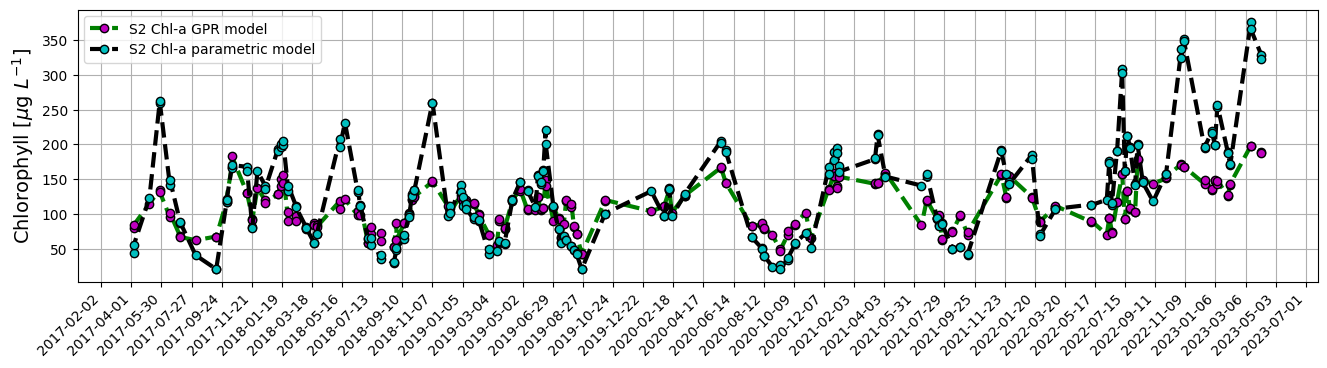

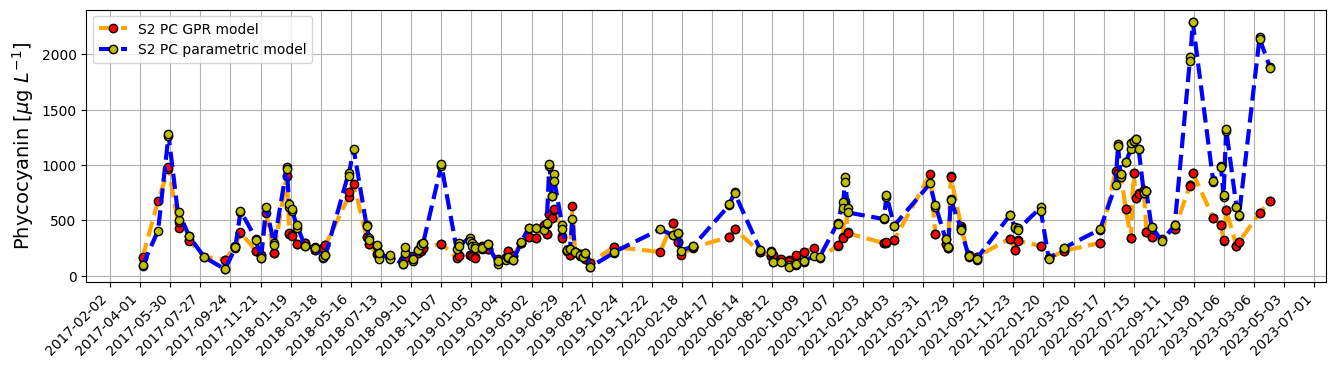

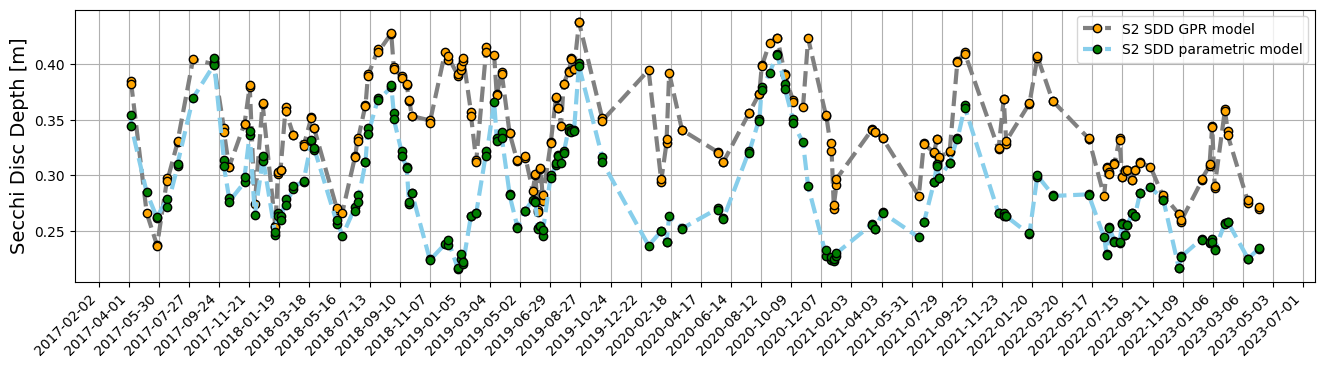

In [117]:
# Water ecological variables time series plotting - Albufera mask

df_GPR_CHL = chart_ts_GPR_CHL.dataframe
df_PI_CHL = chart_ts_PI_CHL.dataframe

df_GPR_PC = chart_ts_GPR_PC.dataframe
df_PI_PC = chart_ts_PI_PC.dataframe

df_GPR_SDD = chart_ts_GPR_SDD.dataframe
df_PI_SDD = chart_ts_PI_SDD.dataframe

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
df_GPR_CHL.plot(y='Chl', kind='line',figsize=(16,4),color='green', ax=ax,linestyle="--",marker="o",markerfacecolor='m',markeredgecolor='k',markersize=6,lw=3,label='S2 Chl-a GPR model');
df_PI_CHL.plot(y='chlro', kind='line',figsize=(16,4),lw=3,color='black', ax=ax,linestyle="--",marker="o",markerfacecolor='c',markeredgecolor='k',markersize=6,label='S2 Chl-a parametric model');
plt.legend()
plt.ylabel('Chlorophyll [$\mu$g $L^{-1}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
df_GPR_PC.plot(y='PC', kind='line',figsize=(16,4),color='orange', ax=ax,linestyle="--",marker="o",markerfacecolor='r',markeredgecolor='k',markersize=6,lw=3,label='S2 PC GPR model');
df_PI_PC.plot(y='fico', kind='line',figsize=(16,4),lw=3,color='blue', ax=ax,linestyle="--",marker="o",markerfacecolor='y',markeredgecolor='k',markersize=6,label='S2 PC parametric model');
plt.legend()
plt.ylabel('Phycocyanin [$\mu$g $L^{-1}$]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

plt.figure(figsize= (16,4))
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(axmaxloc))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(axminloc))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
df_GPR_SDD.plot(y='ZSD', kind='line',figsize=(16,4),color='grey', ax=ax,linestyle="--",marker="o",markerfacecolor='orange',markeredgecolor='k',markersize=6,lw=3,label='S2 SDD GPR model');
df_PI_SDD.plot(y='Secchi', kind='line',figsize=(16,4),lw=3,color='skyblue', ax=ax,linestyle="--",marker="o",markerfacecolor='g',markeredgecolor='k',markersize=6,label='S2 SDD parametric model');
plt.legend()
plt.ylabel('Secchi Disc Depth [m]',fontsize='14')
plt.grid(1)
plt.xticks(rotation=45, ha='right')
plt.show()

Exporting water parameters time series data

In [139]:
Dates_S2_ID = np.arange(1,S2_GPR_CHL_image_nparray.shape[2]+1)
df_dates_S2 = pd.DataFrame(Dates_S2, columns=['Dates_S2'])
df_ID = pd.DataFrame(Dates_S2_ID, columns=['ID'])

# concatenating df_dates_S2 and df_ID along columns
df_dates_S2_concatenated = pd.concat([df_ID, df_dates_S2], axis=1)
display(df_dates_S2_concatenated)
df_concatenated_time_series = pd.concat([df_GPR_CHL, df_GPR_PC, df_GPR_SDD, df_PI_CHL, df_PI_PC, df_PI_SDD], axis=1)


df_concatenated_time_series.rename(columns = {'Chl':'CHL_GPR', 'PC':'PC_GPR','ZSD':'SDD_GPR','chlro':'CHL_PI','fico':'PC_PI','Secchi':'SDD_PI'}, inplace = True)
df_concatenated_time_series.to_csv('/content/drive/MyDrive/water parameters time series.csv', index=True,header=True)
df_dates_S2_concatenated.to_csv('/content/drive/MyDrive/water parameters dates ID.csv', index=True,header=True)
df_concatenated_time_series.to_csv('water parameters time series.csv',sep=',',header=True)
df_dates_S2_concatenated.to_csv('water parameters dates ID.csv',sep=',',header=True)
display(df_concatenated_time_series)

,ID,Dates_S2
0,1,2017-04-06
1,2,2017-04-06
2,3,2017-05-06
3,4,2017-05-26
4,5,2017-05-26
...,...,...
229,230,2023-02-04
230,231,2023-03-16
231,232,2023-03-16
232,233,2023-04-05


,CHL_GPR,PC_GPR,SDD_GPR,CHL_PI,PC_PI,SDD_PI
2017-04-06 10:53:17.631,79.623224,162.645120,0.384195,43.817785,84.769270,0.354375
2017-04-06 10:53:17.631,84.499133,169.021320,0.381869,56.111087,95.288374,0.344108
2017-05-06 10:50:29.462,114.855674,678.424714,0.266307,122.817137,409.258158,0.284825
2017-05-26 10:55:18.082,134.909014,964.014215,0.237535,260.015077,1261.448823,0.261994
2017-05-26 10:55:18.082,132.367350,985.987864,0.236966,262.383510,1282.931872,0.262985
...,...,...,...,...,...,...
2023-02-04 11:00:13.814,143.577793,306.710890,0.336225,171.313625,545.927833,0.258466
2023-03-16 11:00:11.797,198.217936,566.819362,0.275678,375.936278,2157.976994,0.225353
2023-03-16 11:00:12.478,197.764761,568.894792,0.277691,365.088668,2138.920971,0.225629
2023-04-05 11:00:14.001,189.385056,673.886455,0.270275,328.936418,1885.490303,0.234188


## Macrophytes detection

In [58]:
# Add NDWI_mask band to an image collection
NDWI_collection = S2collection_raw.map(addNDWI).select('NDWI').map(clipcol)
S2_NDWI_mask_image = NDWI_collection.toBands() # Use this option if you want to unmask the land surface surrounding the lagoon
#S2_NDWI_mask_image = NDWI_collection.toBands().unmask(0);

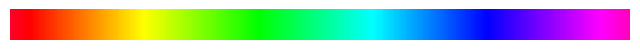

In [59]:
palette_NDWI = cm.get_palette('gist_rainbow', n_class=10)
vis_NDWI = {'min': -1, 'max': 0, 'palette': palette_NDWI}
cm.plot_colormap('gist_rainbow', width=8.0, height=0.4, orientation='horizontal')

In [66]:
u_lat = 39.34
u_lon = -0.35

Map_S2_NDWI = geemap.Map()
Map_S2_NDWI = geemap.Map(center=(u_lat,u_lon), zoom=13)
Map_S2_NDWI.set_plot_options(add_marker_cluster=True)
Map_S2_NDWI

Map(center=[39.34, -0.35], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(childre…

In [67]:
Map_S2_NDWI.addLayer(roi_Albufera, {},'Albufera ROI',opacity = 0.7)
Map_S2_NDWI.addLayer(S2image, vizParams,'S2 RGB composite')
#Map_S2_2.add_time_slider(NDWI_collection ,vis_NDWI, region=roi_Albufera,layer_name='S2 NDWI Time-series',labels=labels_S2, time_interval=1)
Map_S2_NDWI.addLayer(S2_NDWI_mask_image.select(212),vis_NDWI,'S2 NDWI')
Map_S2_NDWI.add_colorbar(vis_NDWI, label="NDWI", orientation="horizontal", layer_name="NDWI")